In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib.pyplot as plt
import itertools
import powerlaw
import math
import warnings
import cairocffi as cairo

warnings.filterwarnings('ignore')

In [2]:
cType =  'lockdown'
beginDate = '2020-03-16'
endDate = '2020-06-30'

## Read graph dataset (from Dataverse)

In [21]:
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
all_data = pd.read_csv('edges.csv', parse_dates=['Date'], date_parser=dateparse)
all_data.set_index('Date', inplace=True)

In [22]:
all_data.head()

,Sender,Receiver
Date,,
2019-12-31 15:30:28,466424,461836
2019-12-31 15:30:28,466424,20923
2019-12-31 15:30:44,39527,30652
2019-12-31 15:30:59,466424,461836
2019-12-31 15:30:59,466424,20923


In [23]:
all_data = all_data.loc[beginDate:endDate]

In [24]:
all_data.reset_index(drop=False, inplace=True)
all_data.head()

,Date,Sender,Receiver
0,2020-03-16 00:00:00,39848,462263
1,2020-03-16 00:00:00,39848,468258
2,2020-03-16 00:00:07,24351,465271
3,2020-03-16 00:02:08,45076,463558
4,2020-03-16 00:02:15,39534,462961


In [25]:
count_groupby = all_data.groupby(['Sender', 'Receiver']).agg('count')
#count_groupby

In [26]:
count_groupby.to_csv('count_groupby_edges_{}.csv'.format(cType),header=False)

In [3]:
df_g = pd.read_csv('count_groupby_edges_{}.csv'.format(cType),names=['Sender','Receiver','Num_Mails'])
df_g.head()

,Sender,Receiver,Num_Mails
0,0,9,1
1,0,569,8
2,0,1321,3
3,0,2120,2
4,0,4078,2


In [4]:
#df_g.sort_values(by=['Num_Mails'],  ascending=False)

In [5]:
df_g['Num_Mails'].describe()

count    782910.000000
mean         11.241168
std         357.378393
min           1.000000
25%           1.000000
50%           2.000000
75%           5.000000
max      142711.000000
Name: Num_Mails, dtype: float64

In [6]:
tuples = [tuple(x) for x in df_g.values]
Gm = ig.Graph.TupleList(tuples, directed = True, edge_attrs = ['Num_Mails'])

## Describing the directed graph

#### Density

In [77]:
Gm_density = Gm.density(loops=False)
print ("Density : ", Gm_density)

Density :  2.420886054544309e-05


#### Diameter

In [78]:
Gm_diameter = Gm.diameter()
print ("Diameter : ",Gm_diameter)

Diameter :  14


#### Diameter Giant Component

In [79]:
def giant_component(graph):
    """Compute giant component.

    Returns:
        The giant component of `graph` as an `igraph.Graph`.

    """
    vc = graph.components()
    vc_sizes = vc.sizes()
    return vc.subgraph(vc_sizes.index(max(vc_sizes)))
Gm_diameter_gc =  giant_component(Gm).diameter()
print ("Diameter giant component : ",Gm_diameter_gc)

Diameter giant component :  14


#### Avg. path length

In [80]:
Gm_avg_shortest_path = Gm.average_path_length()
print ("Avg. path length : ",Gm_avg_shortest_path)

Avg. path length :  4.199333097879434


#### Sending nodes

In [81]:
Sending_nodes=df_g['Sender'].nunique()
print("Sending nodes",Sending_nodes)

Sending nodes 65933


#### Receiving nodes

In [82]:
Receiving_nodes = df_g['Receiver'].nunique()
print ("Receiving nodes", Receiving_nodes)

Receiving nodes 122356


#### Total nodes

In [83]:
Gm_total_nodes = Gm.vcount()
print ("Total nodes", Gm_total_nodes)

Total nodes 149091


#### Total Edges

In [84]:
Gm_total_edges = Gm.ecount()
print ("Total edges", Gm_total_edges)

Total edges 538114


#### Global clustering coefficient

In [85]:
Gm_gcc = Gm.transitivity_undirected()
print('Global clustering coefficient: {}'.format(Gm_gcc))

Global clustering coefficient: 0.017145405707678116


#### Local average clustering coefficient

In [86]:
Gm_lacc = Gm.transitivity_avglocal_undirected()
print('Local average clustering coefficient: {}'.format( Gm_lacc ) )

Local average clustering coefficient: 0.46307674421883305


#### Number of 3-cliques(triangles)

In [ ]:
tc= Gm.cliques(min=3,max=3)
print('Number of 3-cliques(triangles): {}'.format(len(tc)))

#### Average triangles formed by an edge

In [ ]:
tf=[]
for i in range(len(Gm.vs)):
    n=0
    for t in tc:
        if i in t:
            n+=1
    tf.append(n)
at = np.mean(tf)
print('Average triangles formed by an edge: {}'.format(at))

## Summary of properties

In [ ]:
G_properties = pd.DataFrame(
    {'Variable': ["Density", 
                  "Diameter", 
                  "Diameter giant component",
                  "Avg. path length",
                  "Sending nodes",
                  "Receiving nodes",
                  "Total nodes", 
                  "Total edges", 
                  'Global clustering coefficient',
                  'Local average clustering coefficient',
                  'Number of 3-cliques(triangles)',
                  'Average triangles formed by an edge'
                 ],
     'Value': [Gm_density,
               Gm_diameter,
               Gm_diameter_gc,
               Gm_avg_shortest_path,
               Sending_nodes, 
               Receiving_nodes,
               Gm_total_nodes,
               Gm_total_edges,
               Gm_gcc,
               Gm_lacc,
               len(tc),
               at
              ],
    })

G_properties.to_csv('output/G_properties_{}.csv'.format(cType),header=False)

## Visualization of degrees

In [ ]:
degree = powerlaw.Fit(Gm.degree(), discrete = True)
print("Alpha degree:", -degree.power_law.alpha)
print("Sigma degree:", degree.power_law.sigma)
print("Xmin degree:",degree.power_law.xmin)
print("Xmin degree:",degree.power_law.xmax)

## Power law

In [18]:
def Fig_Degree(G,xmax):
    degree = powerlaw.Fit(G.degree(), discrete = True)

    Fig_Degree = degree.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
    degree.power_law.plot_ccdf(color='b', linestyle='--', ax=Fig_Degree, label=r"Fit, no $x_{max}$")
    degree_max = powerlaw.Fit(G.degree(), discrete=True, xmax=xmax)
    degree_max.plot_ccdf(color='r', label=r"Empirical, $x_{max} = $" + str(xmax))
    degree_max.power_law.plot_ccdf(color='r', linestyle='--', ax=Fig_Degree, label=r"Fit, $x_{max} = $" + str(xmax))

    Fig_Degree.set_ylabel(u"CCDF")
    Fig_Degree.set_xlabel(r"Node Degree")
    handles, labels = Fig_Degree.get_legend_handles_labels()
    leg = Fig_Degree.legend(handles, labels, loc=3)
    leg.draw_frame(False)
    
    Fig_Degree.figure.savefig('Figures/Fig_Degree_{}_{}.png'.format(xmax, cType), dpi=300)
    
    return Fig_Degree


In [7]:
def Fig_In_Degree(G, xmax):
    in_degree = powerlaw.Fit(G.indegree(), discrete = True)

    Fig_In_Degree = in_degree.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
    in_degree.power_law.plot_ccdf(color='b', linestyle='--', ax=Fig_In_Degree, label=r"Fit, no $x_{max}$")
    in_degree_max = powerlaw.Fit(G.indegree(), discrete=True, xmax = xmax)
    in_degree_max.plot_ccdf(color='r', label=r"Empirical, $x_{max} = $" + str(xmax))
    in_degree_max.power_law.plot_ccdf(color='r', linestyle='--', ax=Fig_In_Degree, label=r"Fit, $x_{max} = $" + str(xmax))
    
    Fig_In_Degree.set_ylabel(u"CCDF")
    Fig_In_Degree.set_xlabel(r"Node In-Degree")
    handles, labels = Fig_In_Degree.get_legend_handles_labels()
    leg = Fig_In_Degree.legend(handles, labels, loc=3)
    leg.draw_frame(False)
    
    Fig_In_Degree.figure.savefig('Figures/Fig_In_Degree_{}_{}.png'.format(xmax,cType), dpi=300)

    
    return Fig_In_Degree

In [8]:
def Fig_Out_Degree(G,xmax):
    out_degree = powerlaw.Fit(G.outdegree(), discrete = True)

    Fig_Out_Degree = out_degree.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
    out_degree.power_law.plot_ccdf(color='b', linestyle='--', ax=Fig_Out_Degree, label=r"Fit, no $x_{max}$")
    out_degree_max = powerlaw.Fit(G.outdegree(), discrete=True, xmax = xmax)
    out_degree_max.plot_ccdf(color='r', label=r"Empirical, $x_{max} = $" + str(xmax))
    out_degree_max.power_law.plot_ccdf(color='r', linestyle='--', ax=Fig_Out_Degree, label=r"Fit, $x_{max} = $" + str(xmax))

    Fig_Out_Degree.set_ylabel(u"CCDF")
    Fig_Out_Degree.set_xlabel(r"Node Out-Degree")
    #Fig_Out_Degree.set_title(" Out-Degree")
    handles, labels = Fig_Out_Degree.get_legend_handles_labels()
    leg = Fig_Out_Degree.legend(handles, labels, loc=3)
    leg.draw_frame(False)
    
    Fig_Out_Degree.figure.savefig('Figures/Fig_Out_Degree{}_{}.png'.format(xmax,cType), dpi=300)

    
    return Fig_Out_Degree

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


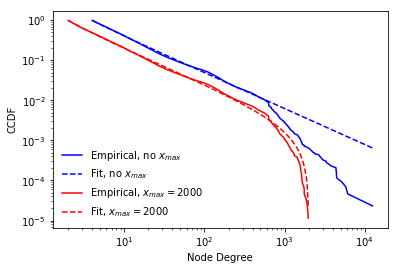

In [19]:
figura = Fig_Degree(Gm, 2000)

In [ ]:
type(figura)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


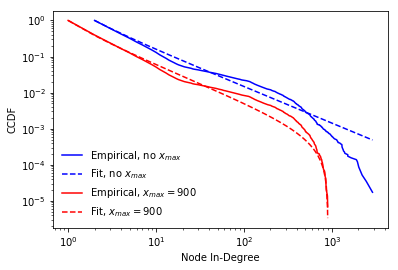

In [9]:
Fig_In_Degree(Gm, 900)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


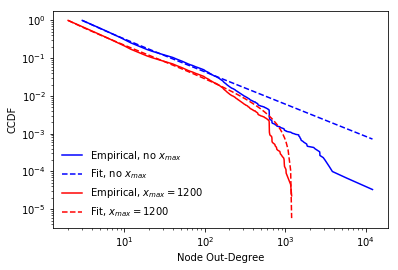

In [10]:
Fig_Out_Degree(Gm, 1200)

## Strength

In [11]:
def Fig_Strength(G,xmax):
    strength = powerlaw.Fit(G.strength(mode="ALL", weights='Num_Mails'), discrete = True)

    Fig_Strength = strength.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
    strength.power_law.plot_ccdf(color='b', linestyle='--', ax=Fig_Strength, label=r"Fit, no $x_{max}$")
    strength_max = powerlaw.Fit(G.strength(mode="ALL", weights='Num_Mails'), discrete=True, xmax = xmax)
    strength_max.plot_ccdf(color='r', label=r"Empirical, $x_{max} = $" + str(xmax))
    strength_max.power_law.plot_ccdf(color='r', linestyle='--', ax=Fig_Strength, label=r"Fit, $x_{max} = $" + str(xmax))

    Fig_Strength.set_ylabel(u"CCDF")
    Fig_Strength.set_xlabel(r"Node Strength")
    #Fig_Strength.set_title(" Strength")
    handles, labels = Fig_Strength.get_legend_handles_labels()
    leg = Fig_Strength.legend(handles, labels, loc=3)
    leg.draw_frame(False)
    
    Fig_Strength.figure.savefig('Figures/Fig_Strength_{}_{}.png'.format(xmax,cType), dpi=300)
    
    return Fig_Strength

In [12]:
def Fig_In_Strength(G,xmax):
    in_strength = powerlaw.Fit(G.strength(mode="IN", weights='Num_Mails'), discrete = True)

    Fig_In_Strength = in_strength.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
    in_strength.power_law.plot_ccdf(color='b', linestyle='--', ax=Fig_In_Strength, label=r"Fit, no $x_{max}$")
    in_strength_max = powerlaw.Fit(G.strength(mode="IN", weights='Num_Mails'), discrete=True, xmax = xmax)
    in_strength_max.plot_ccdf(color='r', label=r"Empirical, $x_{max} = $" + str(xmax))
    in_strength_max.power_law.plot_ccdf(color='r', linestyle='--', ax=Fig_In_Strength, label=r"Fit, $x_{max} = $" + str(xmax))

    Fig_In_Strength.set_ylabel(u"CCDF")
    Fig_In_Strength.set_xlabel(r"Node In-Degree")
    #Fig_In_Strength.set_title(" In-Strength")
    handles, labels = Fig_In_Strength.get_legend_handles_labels()
    leg = Fig_In_Strength.legend(handles, labels, loc=3)
    leg.draw_frame(False)
    
    Fig_In_Strength.figure.savefig('Figures/Fig_In_Strength_{}_{}.png'.format(xmax,cType), dpi=300)
    
    return Fig_In_Strength

In [13]:
def Fig_Out_Strength(G,xmax):
    out_strength = powerlaw.Fit(G.strength(mode="OUT", weights='Num_Mails'), discrete = True)

    Fig_Out_Strength = out_strength.plot_ccdf(color='b', label=r"Empirical, no $x_{max}$")
    out_strength.power_law.plot_ccdf(color='b', linestyle='--', ax=Fig_Out_Strength, label=r"Fit, no $x_{max}$")
    out_strength_max = powerlaw.Fit(G.strength(mode="OUT", weights='Num_Mails'), discrete=True, xmax = xmax)
    out_strength_max.plot_ccdf(color='r', label=r"Empirical, $x_{max} = $" + str(xmax))
    out_strength_max.power_law.plot_ccdf(color='r', linestyle='--', ax=Fig_Out_Strength, label=r"Fit, $x_{max} = $" + str(xmax))

    Fig_Out_Strength.set_ylabel(u"CCDF")
    Fig_Out_Strength.set_xlabel(r"Node In-Degree")
    #Fig_Out_Strength.set_title(" Out-Strength")
    handles, labels = Fig_Out_Strength.get_legend_handles_labels()
    leg = Fig_Out_Strength.legend(handles, labels, loc=3)
    leg.draw_frame(False)
    
    Fig_Out_Strength.figure.savefig('Figures/Fig_Out_Strength_{}_{}.png'.format(xmax,cType), dpi=300)
    
    return Fig_Out_Strength

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


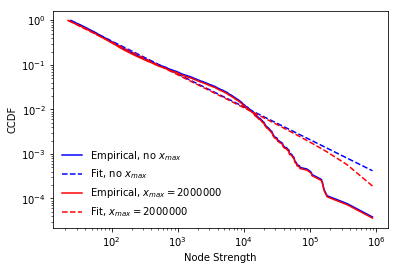

In [14]:
Fig_Strength(Gm, 2000000)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


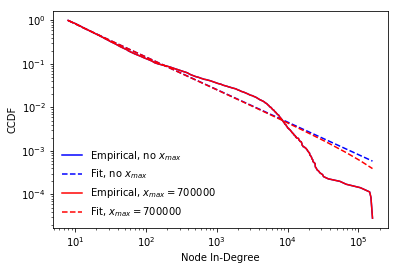

In [15]:
Fig_In_Strength(Gm, 700000)

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


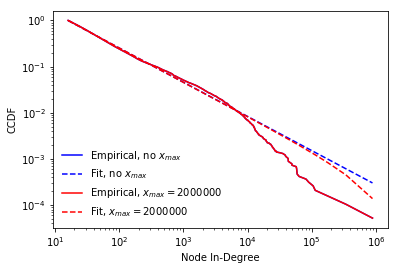

In [16]:
Fig_Out_Strength(Gm, 2000000)

## Betweenness

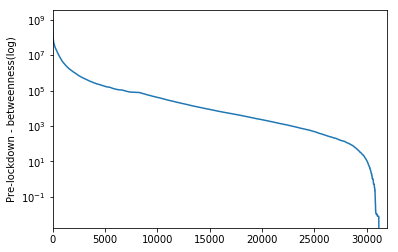

In [9]:
import os.path
import pickle

if os.path.isfile('output/betweenness_{}.pkl'.format(cType)):
    with open('output/betweenness_{}.pkl'.format(cType), 'rb') as f:
        btw = pickle.load(f)
else:
    btw = sorted(Gm.betweenness(), reverse=True)

x=list(range(len(btw)))

plt.plot(x,btw)
plt.xlim([-10,32000])
plt.yscale('log')
plt.ylabel('Lockdown - betweenness(log)')
plt.savefig('Figures/betweenness_{}.png'.format(cType), dpi=300)
plt.show()


In [8]:
import pickle
with open('output/betweenness_{}.pkl'.format(cType), 'wb') as f:
    pickle.dump(btw, f)
#with open('output/betweenness_{}.pkl'.format(cType), 'rb') as f:
#    btw = pickle.load(f)

## Graph viz

In [ ]:
out_fig_name = "Figures/graph_{}.eps".format(cType)

visual_style = {}

# Define colors used for outdegree visualization
colours = ['#fecc5c', '#a31a1c']

# Set bbox and margin
visual_style["bbox"] = (3000,3000)
visual_style["margin"] = 17

# Set vertex colours
visual_style["vertex_color"] = 'grey'

# Set vertex size
visual_style["vertex_size"] = 20

# Set vertex lable size
visual_style["vertex_label_size"] = 8

# Don't curve the edges
visual_style["edge_curved"] = False

# Set the layout
my_layout = Gm.layout_fruchterman_reingold()
visual_style["layout"] = my_layout

# Plot the graph
ig.plot(Gm, out_fig_name, **visual_style)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
